In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import utils
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.multiclass import OneVsRestClassifier



In [4]:
# Descargar el dataset desde Kaggle
path = kagglehub.dataset_download("mirichoi0218/insurance")

# Cargar el archivo CSV en un DataFrame
dataset_path = f"{path}/insurance.csv"
data = pd.read_csv(dataset_path)


In [5]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [8]:
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [9]:
# Identificar duplicados
duplicados = data.duplicated()
# Contar el número de duplicados
num_duplicados = duplicados.sum()
print(f"Número de registros duplicados: {num_duplicados}")
data.loc[duplicados].head(3)

Número de registros duplicados: 1


,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


Eliminamos los duplicados

In [10]:
data = data.drop_duplicates() # Eliminar duplicados

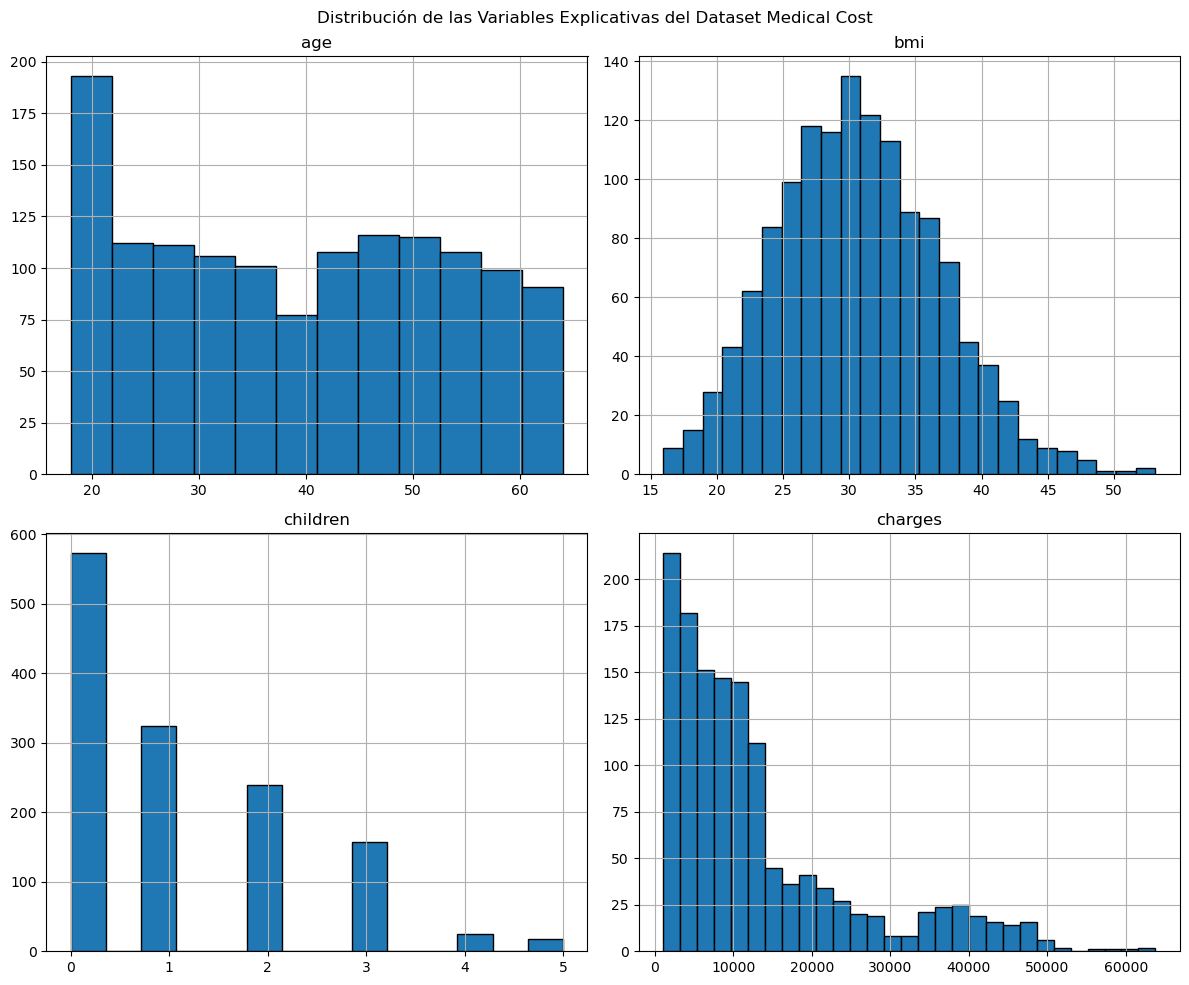

In [11]:
# Crear histogramas para cada característica
data.hist(bins='auto', figsize=(12, 10), edgecolor='black')
plt.suptitle('Distribución de las Variables Explicativas del Dataset Medical Cost')
plt.tight_layout()
plt.show()

In [12]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [13]:
data2 = data.copy()

In [14]:
data2['smoker'] = data2['smoker'].map({'yes': True, 'no': False})

In [15]:
data_dict = {
    'age': 'int64',
    'sex': 'category',
    'bmi': 'float64',
    'children': 'int64',
    'smoker': 'bool',
    'region': 'category',
    'charges': 'float64'
}

# Convertir tipos de datos según el diccionario
for column, dtype in data_dict.items():
    data2[column] = data2[column].astype(dtype, errors='ignore')
data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1337 non-null   int64   
 1   sex       1337 non-null   category
 2   bmi       1337 non-null   float64 
 3   children  1337 non-null   int64   
 4   smoker    1337 non-null   bool    
 5   region    1337 non-null   category
 6   charges   1337 non-null   float64 
dtypes: bool(1), category(2), float64(2), int64(2)
memory usage: 56.5 KB


Consistencia en valores categoricos

In [16]:
boolean_columns = data2.select_dtypes(include=['bool'])
boolean_columns.head()

,smoker
0,True
1,False
2,False
3,False
4,False


In [17]:
categorical_columns = data2.select_dtypes(include=['category'])

In [18]:
for col in categorical_columns:
    categorical_columns[col] = categorical_columns[col].apply(utils.limpiar_cadena)
# Verificar los cambios
for col in categorical_columns:
    print(f"\nValores únicos después de limpieza en '{col}':")
    print(categorical_columns[col].unique())


Valores únicos después de limpieza en 'sex':
['female', 'male']
Categories (2, object): ['female', 'male']

Valores únicos después de limpieza en 'region':
['southwest', 'southeast', 'northwest', 'northeast']
Categories (4, object): ['northeast', 'northwest', 'southeast', 'southwest']


Columnas numericas

In [19]:
numerical_columns = data.select_dtypes(include=[np.number])

In [20]:
utils.calculate_na_statistics(numerical_columns)

,datos sin NAs en q,Na en q,Na en %
age,1337,0,0.0
bmi,1337,0,0.0
children,1337,0,0.0
charges,1337,0,0.0


In [21]:
# Create a summary DataFrame for outliers
outliers_summary = pd.DataFrame()
for column in numerical_columns:
    outliers = utils.detect_outliers_iqr(data[column])
    outliers_summary[column] = {
        'Number of Outliers': outliers.sum(),
        'Percentage of Outliers': 100 * outliers.mean(),
        'Lower Bound': data[column][~outliers].min(),
        'Upper Bound': data[column][~outliers].max()
    }

# Save the summary to a CSV file
outliers_summary.T

,Number of Outliers,Percentage of Outliers,Lower Bound,Upper Bound
age,0.0,0.000000,18.0000,64.000
bmi,9.0,0.673149,15.9600,46.750
children,0.0,0.000000,0.0000,5.000
charges,139.0,10.396410,1121.8739,34472.841


In [22]:
# Crear un diccionario para almacenar las estadísticas
estadisticas_dict = {}
# Iterar sobre cada columna numérica y calcular las estadísticas
for columna in numerical_columns:
    datos_columna = data[columna].values
    estadisticas = utils.calcular_estadisticas(columna, datos_columna)
    estadisticas_dict[columna] = estadisticas
# Convertir el diccionario a un DataFrame para una mejor visualización
estadisticas_df = pd.DataFrame(estadisticas_dict).T  # Transponer para que las columnas sean las filas
estadisticas_df = estadisticas_df[['Cuenta', 'Media', 'Mediana', 'Desviación Estándar', 
                                   'Mínimo', 'Máximo', '25% Percentil', '75% Percentil']]
# Redondear las estadísticas a 2 decimales
estadisticas_df = estadisticas_df.round(2)
# Mostrar el DataFrame formateado
print("\nEstadísticas Descriptivas (Redondeadas a 2 decimales):")
estadisticas_df


Estadísticas Descriptivas (Redondeadas a 2 decimales):


,Cuenta,Media,Mediana,Desviación Estándar,Mínimo,Máximo,25% Percentil,75% Percentil
age,1337.0,39.22,39.00,14.04,18.00,64.00,27.00,51.00
bmi,1337.0,30.66,30.40,6.10,15.96,53.13,26.29,34.70
children,1337.0,1.10,1.00,1.21,0.00,5.00,0.00,2.00
charges,1337.0,13279.12,9386.16,12110.36,1121.87,63770.43,4746.34,16657.72


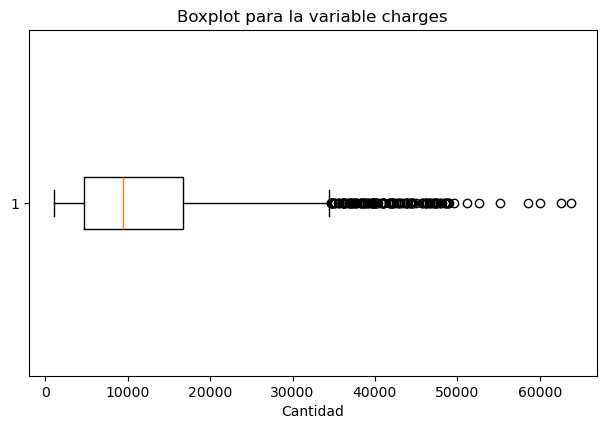

In [23]:
# Identify columns with more than 5% of outliers
columns_with_outliers = outliers_summary.columns[outliers_summary.loc['Percentage of Outliers'] > 5]
# Filter the original DataFrame to include only these columns
df_outliers = data[columns_with_outliers]
# Create separate box plots for each column with more than 5% outliers in a 2x2 grid
plt.figure(figsize=(12, 8))
for i, column in enumerate(columns_with_outliers, 1):
    plt.subplot(2, 2, i)
    plt.boxplot(df_outliers[column].dropna(), vert=False)
    plt.title(f"Boxplot para la variable {column}")
    plt.xlabel("Cantidad")
plt.tight_layout()
plt.show()


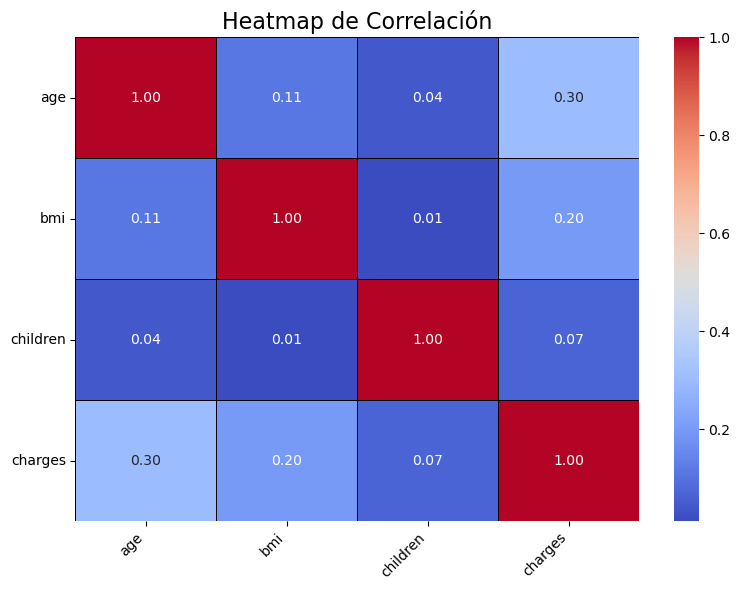

In [24]:
# Crear la figura y el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(numerical_columns.corr(), annot=True  ,fmt=".2f", cmap='coolwarm', linewidths=0.5, linecolor='black')

# Agregar título y ajustar el diseño
plt.title('Heatmap de Correlación', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Mostrar el gráfico
plt.tight_layout
plt.show()

Text(0, 0.5, 'Features')

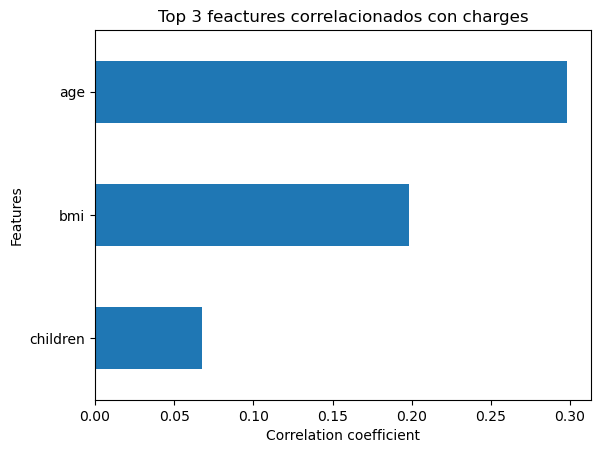

In [25]:
plt.figure()
numerical_columns.corr().charges.apply(lambda x: abs(x)).sort_values(ascending=False).iloc[1:11][::-1].plot(kind='barh') 
plt.title("Top 3 feactures correlacionados con charges")
plt.xlabel("Correlation coefficient")
plt.ylabel("Features")

Modeling

In [26]:
data2.head(20)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,True,southwest,16884.92400
1,18,male,33.770,1,False,southeast,1725.55230
2,28,male,33.000,3,False,southeast,4449.46200
3,33,male,22.705,0,False,northwest,21984.47061
4,32,male,28.880,0,False,northwest,3866.85520
5,31,female,25.740,0,False,southeast,3756.62160
6,46,female,33.440,1,False,southeast,8240.58960
7,37,female,27.740,3,False,northwest,7281.50560
8,37,male,29.830,2,False,northeast,6406.41070
9,60,female,25.840,0,False,northwest,28923.13692


In [27]:
data_clean = pd.concat([numerical_columns, categorical_columns, boolean_columns], axis=1)
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1337 non-null   int64   
 1   bmi       1337 non-null   float64 
 2   children  1337 non-null   int64   
 3   charges   1337 non-null   float64 
 4   sex       1337 non-null   category
 5   region    1337 non-null   category
 6   smoker    1337 non-null   bool    
dtypes: bool(1), category(2), float64(2), int64(2)
memory usage: 56.5 KB


In [28]:
data_clean.head()


,age,bmi,children,charges,sex,region,smoker
0,19,27.900,0,16884.92400,female,southwest,True
1,18,33.770,1,1725.55230,male,southeast,False
2,28,33.000,3,4449.46200,male,southeast,False
3,33,22.705,0,21984.47061,male,northwest,False
4,32,28.880,0,3866.85520,male,northwest,False


In [29]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1337 non-null   int64   
 1   bmi       1337 non-null   float64 
 2   children  1337 non-null   int64   
 3   charges   1337 non-null   float64 
 4   sex       1337 non-null   category
 5   region    1337 non-null   category
 6   smoker    1337 non-null   bool    
dtypes: bool(1), category(2), float64(2), int64(2)
memory usage: 56.5 KB


Modeling

In [52]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

# Definimos las columnas de cada tipo
num_features = ['age', 'bmi']
cat_features = ['sex', 'smoker', 'region']
ordinal_features = ['children']

# Configuración de transformación para las características ordinales
ordinal_transformer = OrdinalEncoder(categories=[[0, 1, 2, 3, 4, 5]])

# Configuración de transformación para las características categóricas
cat_transformer = OneHotEncoder(drop='first')  # Evita multicolinealidad eliminando la primera categoría

# Configuración de transformación para las características numéricas
num_transformer = StandardScaler()

# Crear el ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features),
        ('ord', ordinal_transformer, ordinal_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Ajustar el pipeline al conjunto de datos (sin la columna objetivo)
X = data.drop('charges', axis=1)
y = data['charges']
pipeline.fit(X)

# Transformar los datos
X_preprocessed = pipeline.transform(X)

# Verificación de la forma del resultado transformado
print(X_preprocessed.shape)


(1337, 8)


In [54]:
# Obtener los nombres de las columnas de las características transformadas
encoded_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Convertir el resultado a un DataFrame de pandas
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=encoded_feature_names, index=X.index)

In [55]:
X_preprocessed_df

,num__age,num__bmi,cat__sex_male,cat__smoker_yes,cat__region_northwest,cat__region_southeast,cat__region_southwest,ord__children
0,-1.440418,-0.453160,0.0,1.0,0.0,0.0,1.0,0.0
1,-1.511647,0.509422,1.0,0.0,0.0,1.0,0.0,1.0
2,-0.799350,0.383155,1.0,0.0,0.0,1.0,0.0,3.0
3,-0.443201,-1.305052,1.0,0.0,1.0,0.0,0.0,0.0
4,-0.514431,-0.292456,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1333,0.767704,0.050269,1.0,0.0,1.0,0.0,0.0,3.0
1334,-1.511647,0.206053,0.0,0.0,0.0,0.0,0.0,0.0
1335,-1.511647,1.014490,0.0,0.0,0.0,1.0,0.0,0.0
1336,-1.297958,-0.797524,0.0,0.0,0.0,0.0,1.0,0.0


In [56]:
from sklearn.model_selection import train_test_split

# Dividir el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Definición de los modelos
models = {
    'logistic_regression': LogisticRegression(),
    'knn': KNeighborsClassifier(),
    'decision_tree': DecisionTreeClassifier()
}

# Crear pipelines para cada modelo
pipelines = {}
for model_name, model in models.items():
    pipelines[model_name] = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Preprocesador definido previamente
        ('classifier', model)
    ])


In [59]:
# Cálculo de los percentiles
p33 = y.quantile(0.33)
p66 = y.quantile(0.66)

print(f"Percentil 33 (bajo-medio): {p33:.2f}")
print(f"Percentil 66 (medio-alto): {p66:.2f}")

# Cálculo del percentil 25, 50 (mediana) y 75
q1 = y.quantile(0.25)
q3 = y.quantile(0.75)
iqr = q3 - q1

# Límite superior para considerar valores "muy altos"
upper_bound = q3 + 1.5 * iqr

print(f"Percentil 25 (Q1): {q1:.2f}")
print(f"Percentil 75 (Q3): {q3:.2f}")
print(f"Rango intercuartílico (IQR): {iqr:.2f}")
print(f"Límite superior para 'muy alto': {upper_bound:.2f}")

Percentil 33 (bajo-medio): 6198.48
Percentil 66 (medio-alto): 12636.20
Percentil 25 (Q1): 4746.34
Percentil 75 (Q3): 16657.72
Rango intercuartílico (IQR): 11911.37
Límite superior para 'muy alto': 34524.78


charges
Bajo        441
Medio       441
Alto        316
Muy alto    139
Name: count, dtype: int64


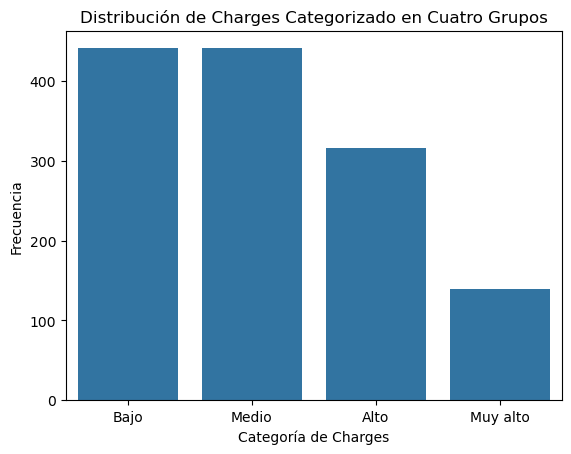

In [60]:
# Crear una variable de respuesta categorizada en cuatro grupos usando el IQR
y_categorized = pd.cut(y, bins=[0, p33, p66, upper_bound, y.max()], labels=['Bajo', 'Medio', 'Alto', 'Muy alto'])

# Verificar la distribución de la nueva variable categorizada
print(y_categorized.value_counts())
sns.countplot(x=y_categorized)
plt.title('Distribución de Charges Categorizado en Cuatro Grupos')
plt.xlabel('Categoría de Charges')
plt.ylabel('Frecuencia')
plt.show()

Percentil 25 (Q1): 4746.34
Mediana (Q2): 9386.16
Percentil 75 (Q3): 16657.72
charges
Bajo          335
Medio-Bajo    334
Medio-Alto    334
Alto          334
Name: count, dtype: int64


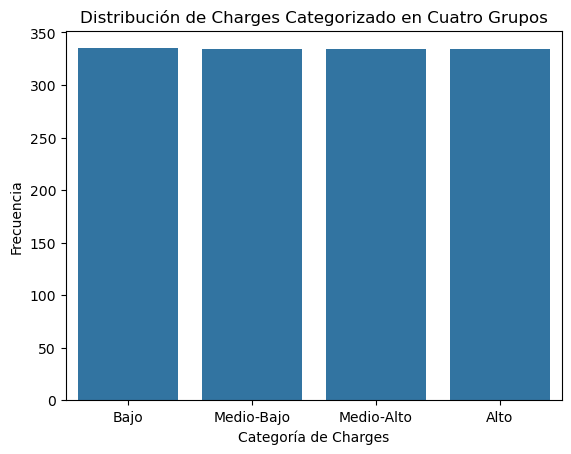

In [61]:
# Cálculo de los cuartiles
q1 = y.quantile(0.25)
q2 = y.quantile(0.50)  # Mediana
q3 = y.quantile(0.75)

print(f"Percentil 25 (Q1): {q1:.2f}")
print(f"Mediana (Q2): {q2:.2f}")
print(f"Percentil 75 (Q3): {q3:.2f}")

# Crear una variable de respuesta categorizada en cuatro grupos usando los cuartiles
y_categorized = pd.cut(y, bins=[0, q1, q2, q3, y.max()], labels=['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto'])

# Verificar la distribución de la nueva variable categorizada
print(y_categorized.value_counts())
sns.countplot(x=y_categorized)
plt.title('Distribución de Charges Categorizado en Cuatro Grupos')
plt.xlabel('Categoría de Charges')
plt.ylabel('Frecuencia')
plt.show()

In [62]:
from sklearn.model_selection import train_test_split

# Dividir el dataset en conjuntos de entrenamiento y prueba usando y_categorized
X_train, X_test, y_train, y_test = train_test_split(X, y_categorized, test_size=0.3, random_state=42)

# Verificar la distribución de las clases en y_train e y_test
print("Distribución en y_train:")
print(y_train.value_counts())
print("\nDistribución en y_test:")
print(y_test.value_counts())

Distribución en y_train:
charges
Bajo          237
Medio-Bajo    235
Alto          235
Medio-Alto    228
Name: count, dtype: int64

Distribución en y_test:
charges
Medio-Alto    106
Medio-Bajo     99
Alto           99
Bajo           98
Name: count, dtype: int64


In [63]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

# Definición de los modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# Entrenar y evaluar cada modelo
for model_name, model in models.items():
    # Crear el pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Preprocesador definido previamente
        ('classifier', model)
    ])

    # Entrenar el modelo
    pipeline.fit(X_train, y_train)

    # Predicciones en el conjunto de prueba
    y_pred = pipeline.predict(X_test)

    # Evaluación del modelo
    print(f"\nModelo: {model_name}")
    print("Exactitud:", accuracy_score(y_test, y_pred))
    print("Reporte de clasificación:\n", classification_report(y_test, y_pred, target_names=y_train.cat.categories))
    print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred, labels=y_train.cat.categories))
    # # Matriz de confusión
    # conf_matrix = confusion_matrix(y_test, y_pred, labels=y_train.cat.categories)
    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=y_train.cat.categories, yticklabels=y_train.cat.categories)
    # plt.title(f'Matriz de Confusión - {model_name}')
    # plt.xlabel('Predicción')
    # plt.ylabel('Real')
    # plt.show()



Modelo: Logistic Regression
Exactitud: 0.8482587064676617
Reporte de clasificación:
               precision    recall  f1-score   support

        Bajo       0.93      0.76      0.83        99
  Medio-Bajo       0.89      0.93      0.91        98
  Medio-Alto       0.82      0.83      0.83       106
        Alto       0.78      0.88      0.82        99

    accuracy                           0.85       402
   macro avg       0.85      0.85      0.85       402
weighted avg       0.85      0.85      0.85       402

Matriz de confusión:
 [[91  7  0  0]
 [ 1 87 11  0]
 [ 3  9 88  6]
 [ 7  9  8 75]]

Modelo: K-Nearest Neighbors
Exactitud: 0.7587064676616916
Reporte de clasificación:
               precision    recall  f1-score   support

        Bajo       0.87      0.68      0.76        99
  Medio-Bajo       0.80      0.86      0.83        98
  Medio-Alto       0.72      0.78      0.75       106
        Alto       0.68      0.72      0.70        99

    accuracy                          

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

# Definición de los modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# Entrenar y evaluar cada modelo
for model_name, model in models.items():
    # Crear el pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Preprocesador definido previamente
        ('classifier', model)
    ])

    # Entrenar el modelo
    pipeline.fit(X_train, y_train)

    # Predicciones en el conjunto de prueba
    y_pred = pipeline.predict(X_test)

    # Definir etiquetas explícitamente
    labels = y_train.cat.categories

    # Evaluación del modelo
    print(f"\nModelo: {model_name}")
    print("Exactitud:", accuracy_score(y_test, y_pred))
    print("Reporte de clasificación:\n", classification_report(y_test, y_pred, labels=labels, target_names=labels))
    print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred, labels=labels))


Modelo: Logistic Regression
Exactitud: 0.8482587064676617
Reporte de clasificación:
               precision    recall  f1-score   support

        Bajo       0.89      0.93      0.91        98
  Medio-Bajo       0.78      0.88      0.82        99
  Medio-Alto       0.82      0.83      0.83       106
        Alto       0.93      0.76      0.83        99

    accuracy                           0.85       402
   macro avg       0.85      0.85      0.85       402
weighted avg       0.85      0.85      0.85       402

Matriz de confusión:
 [[91  7  0  0]
 [ 1 87 11  0]
 [ 3  9 88  6]
 [ 7  9  8 75]]

Modelo: K-Nearest Neighbors
Exactitud: 0.7587064676616916
Reporte de clasificación:
               precision    recall  f1-score   support

        Bajo       0.80      0.86      0.83        98
  Medio-Bajo       0.68      0.72      0.70        99
  Medio-Alto       0.72      0.78      0.75       106
        Alto       0.87      0.68      0.76        99

    accuracy                          

In [65]:
from sklearn.model_selection import cross_val_score

# Definir los modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# Realizar validación cruzada y mostrar los resultados
for model_name, model in models.items():
    # Crear el pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Preprocesador definido previamente
        ('classifier', model)
    ])

    # Validación cruzada
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

    # Mostrar resultados
    print(f"\nModelo: {model_name}")
    print(f"Exactitud promedio de validación cruzada: {cv_scores.mean():.4f}")
    print(f"Desviación estándar de validación cruzada: {cv_scores.std():.4f}")
    print(f"Exactitud por partición: {cv_scores}")



Modelo: Logistic Regression
Exactitud promedio de validación cruzada: 0.8278
Desviación estándar de validación cruzada: 0.0254
Exactitud por partición: [0.83957219 0.81818182 0.80748663 0.87165775 0.80213904]

Modelo: K-Nearest Neighbors
Exactitud promedio de validación cruzada: 0.7369
Desviación estándar de validación cruzada: 0.0198
Exactitud por partición: [0.71657754 0.72727273 0.72192513 0.77005348 0.7486631 ]

Modelo: Decision Tree
Exactitud promedio de validación cruzada: 0.7872
Desviación estándar de validación cruzada: 0.0212
Exactitud por partición: [0.80748663 0.80213904 0.79679144 0.7486631  0.78074866]


In [66]:
from sklearn.model_selection import GridSearchCV

# Definición de los hiperparámetros para cada modelo
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1','l2'],
        'classifier__solver': ['liblinear']  # Permite l1 y l2
    },
    'K-Nearest Neighbors': {
        'classifier__n_neighbors': [3, 5, 7, 9, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__criterion': ['gini', 'entropy']
    }
}

# Resultados de búsqueda de hiperparámetros
best_params = {}

# Optimización para cada modelo
for model_name, param_grid in param_grids.items():
    # Crear el pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Preprocesador definido previamente
        ('classifier', models[model_name])  # Modelo a optimizar
    ])

    # Configuración de GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Ejecutar búsqueda de hiperparámetros
    grid_search.fit(X_train, y_train)

    # Guardar y mostrar los mejores resultados
    best_params[model_name] = grid_search.best_params_
    print(f"\nModelo: {model_name}")
    print(f"Mejores hiperparámetros: {grid_search.best_params_}")
    print(f"Mejor exactitud promedio: {grid_search.best_score_:.4f}")



Modelo: Logistic Regression
Mejores hiperparámetros: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Mejor exactitud promedio: 0.7936

Modelo: K-Nearest Neighbors
Mejores hiperparámetros: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 9, 'classifier__weights': 'distance'}
Mejor exactitud promedio: 0.8011

Modelo: Decision Tree
Mejores hiperparámetros: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_split': 10}
Mejor exactitud promedio: 0.8310



--- Evaluación del Modelo: Logistic Regression ---
Reporte de Clasificación:
               precision    recall  f1-score   support

        Bajo       0.94      0.76      0.84        99
  Medio-Bajo       0.83      0.95      0.89        98
  Medio-Alto       0.72      0.78      0.75       106
        Alto       0.73      0.70      0.72        99

    accuracy                           0.80       402
   macro avg       0.80      0.80      0.80       402
weighted avg       0.80      0.80      0.80       402

[[93  5  0  0]
 [ 7 69 23  0]
 [ 3 15 83  5]
 [ 9  5 10 75]]


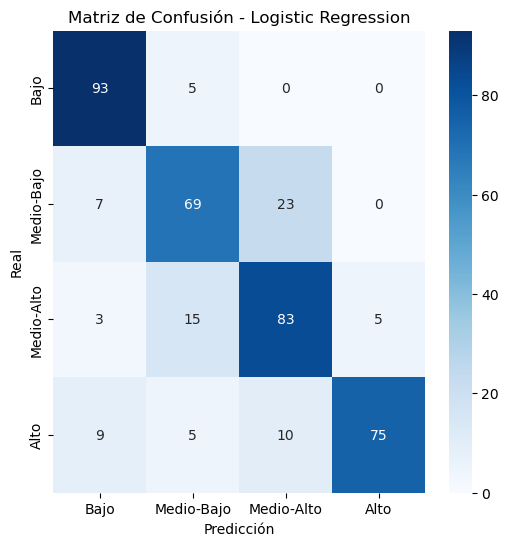

ROC-AUC Promedio (Macro) para Logistic Regression: 0.4172


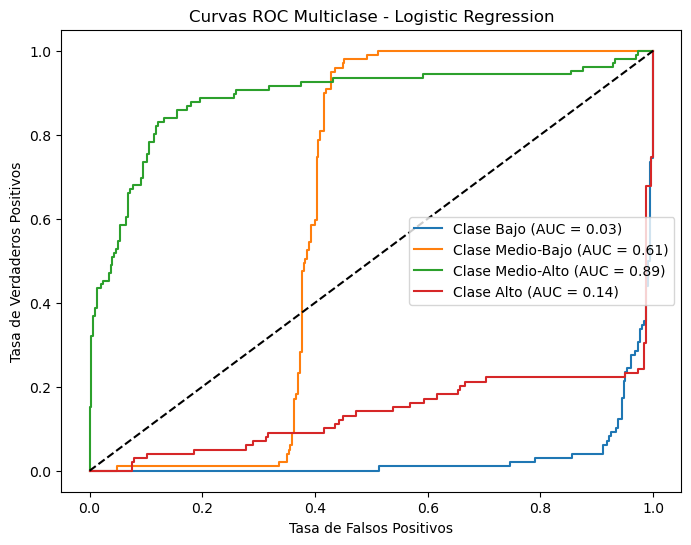


--- Evaluación del Modelo: K-Nearest Neighbors ---
Reporte de Clasificación:
               precision    recall  f1-score   support

        Bajo       0.87      0.68      0.76        99
  Medio-Bajo       0.83      0.87      0.85        98
  Medio-Alto       0.81      0.85      0.83       106
        Alto       0.73      0.82      0.77        99

    accuracy                           0.80       402
   macro avg       0.81      0.80      0.80       402
weighted avg       0.81      0.80      0.80       402

[[85  9  0  4]
 [ 7 81  9  2]
 [ 3  9 90  4]
 [ 8 12 12 67]]


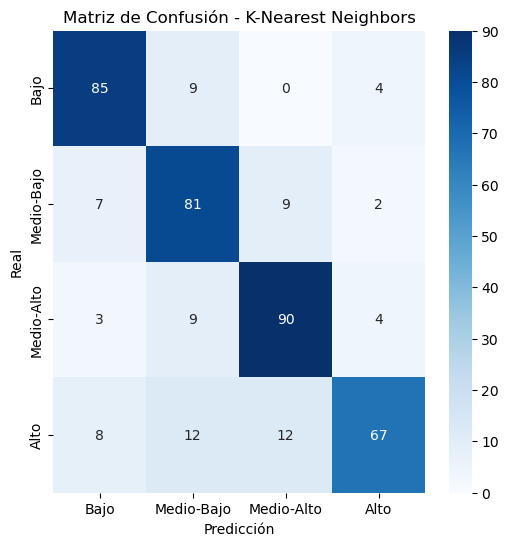


--- Evaluación del Modelo: Decision Tree ---
Reporte de Clasificación:
               precision    recall  f1-score   support

        Bajo       0.76      0.78      0.77        99
  Medio-Bajo       0.85      0.90      0.88        98
  Medio-Alto       0.89      0.80      0.84       106
        Alto       0.86      0.89      0.88        99

    accuracy                           0.84       402
   macro avg       0.84      0.84      0.84       402
weighted avg       0.84      0.84      0.84       402

[[88  2  0  8]
 [ 5 88  2  4]
 [ 2  7 85 12]
 [ 8  5  9 77]]


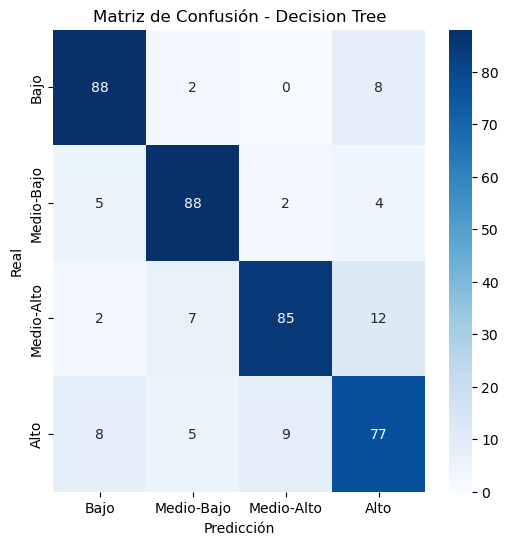

ROC-AUC Promedio (Macro) para Decision Tree: 0.4783


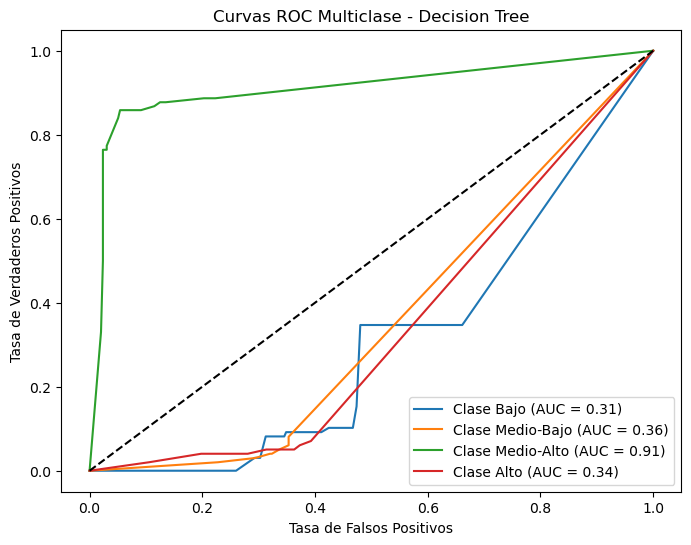

In [67]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# Binarización de las etiquetas para calcular el ROC-AUC multiclase
y_test_binarized = label_binarize(y_test, classes=y_train.cat.categories)

# Resultados de los modelos optimizados
for model_name, model in models.items():
    print(f"\n--- Evaluación del Modelo: {model_name} ---")

    # Quitar el prefijo 'classifier__' de los mejores hiperparámetros
    best_model_params = {k.replace('classifier__', ''): v for k, v in best_params[model_name].items()}

    # Crear el pipeline con los mejores hiperparámetros de cada modelo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model.__class__(**best_model_params))  # Aplicar los mejores hiperparámetros sin prefijo
    ])

    # Entrenar el modelo con el conjunto de entrenamiento completo
    pipeline.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = pipeline.predict(X_test)

    # Reporte de clasificación
    print("Reporte de Clasificación:\n", classification_report(y_test, y_pred, target_names=y_train.cat.categories))

    # Matriz de Confusión
    conf_matrix = confusion_matrix(y_test, y_pred, labels=y_train.cat.categories)
    print(conf_matrix)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=y_train.cat.categories, yticklabels=y_train.cat.categories)
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

    # Calcular el ROC-AUC para cada clase en el enfoque "one-vs-rest"
    if model_name == 'Logistic Regression' or model_name == 'Decision Tree':
        y_pred_proba = pipeline.predict_proba(X_test)

        # Calcular el AUC para cada clase
        roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, average="macro", multi_class="ovr")
        print(f"ROC-AUC Promedio (Macro) para {model_name}: {roc_auc:.4f}")

        # Graficar las curvas ROC para cada clase
        plt.figure(figsize=(8, 6))
        for i, class_name in enumerate(y_train.cat.categories):
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
            plt.plot(fpr, tpr, label=f'Clase {class_name} (AUC = {roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i]):.2f})')

        plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
        plt.title(f'Curvas ROC Multiclase - {model_name}')
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.legend(loc='best')
        plt.show()



--- Evaluación del Modelo: Logistic Regression ---
Reporte de Clasificación:
               precision    recall  f1-score   support

        Bajo       0.83      0.95      0.89        98
  Medio-Bajo       0.73      0.70      0.72        99
  Medio-Alto       0.72      0.78      0.75       106
        Alto       0.94      0.76      0.84        99

    accuracy                           0.80       402
   macro avg       0.80      0.80      0.80       402
weighted avg       0.80      0.80      0.80       402



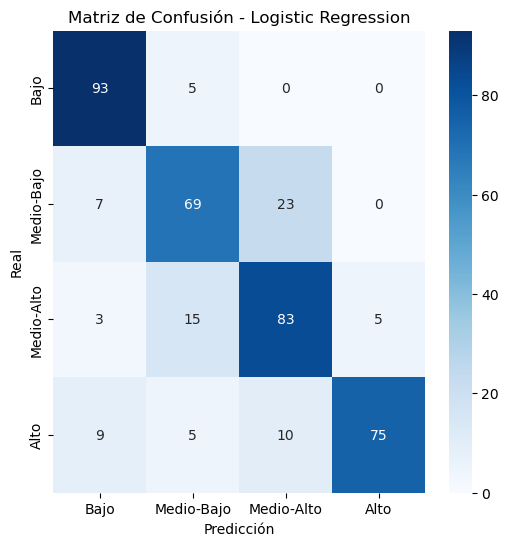

ROC-AUC Promedio (Macro) para Logistic Regression: 0.4172


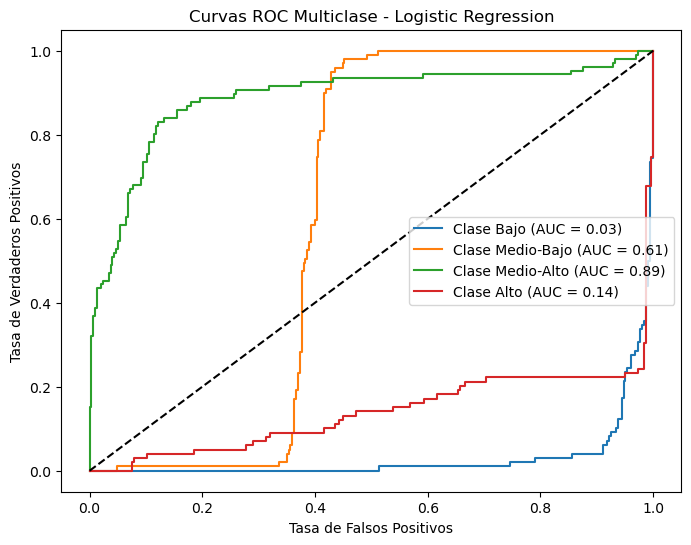


--- Evaluación del Modelo: K-Nearest Neighbors ---
Reporte de Clasificación:
               precision    recall  f1-score   support

        Bajo       0.83      0.87      0.85        98
  Medio-Bajo       0.73      0.82      0.77        99
  Medio-Alto       0.81      0.85      0.83       106
        Alto       0.87      0.68      0.76        99

    accuracy                           0.80       402
   macro avg       0.81      0.80      0.80       402
weighted avg       0.81      0.80      0.80       402



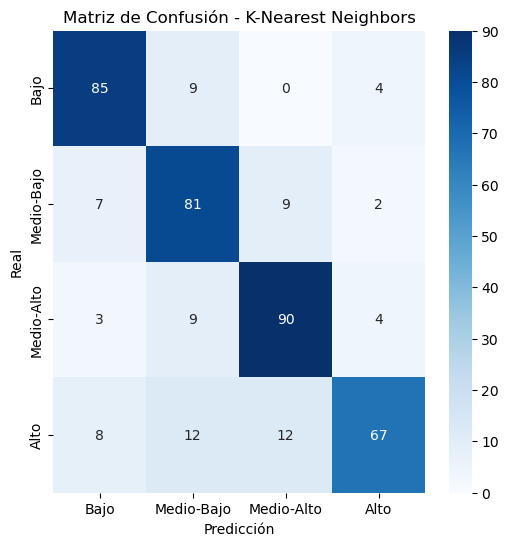


--- Evaluación del Modelo: Decision Tree ---
Reporte de Clasificación:
               precision    recall  f1-score   support

        Bajo       0.85      0.90      0.88        98
  Medio-Bajo       0.86      0.89      0.88        99
  Medio-Alto       0.89      0.80      0.85       106
        Alto       0.76      0.79      0.78        99

    accuracy                           0.84       402
   macro avg       0.84      0.84      0.84       402
weighted avg       0.84      0.84      0.84       402



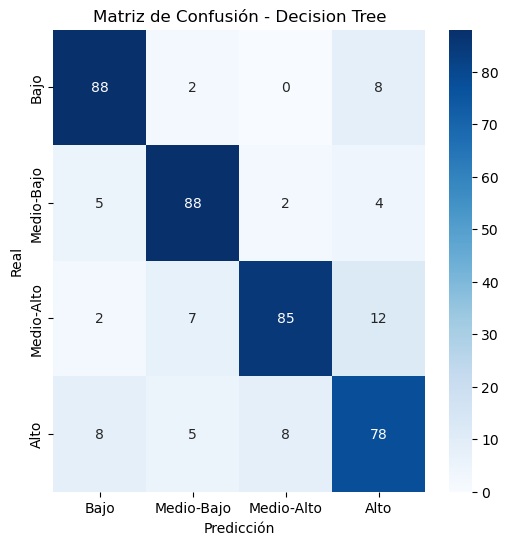

ROC-AUC Promedio (Macro) para Decision Tree: 0.4784


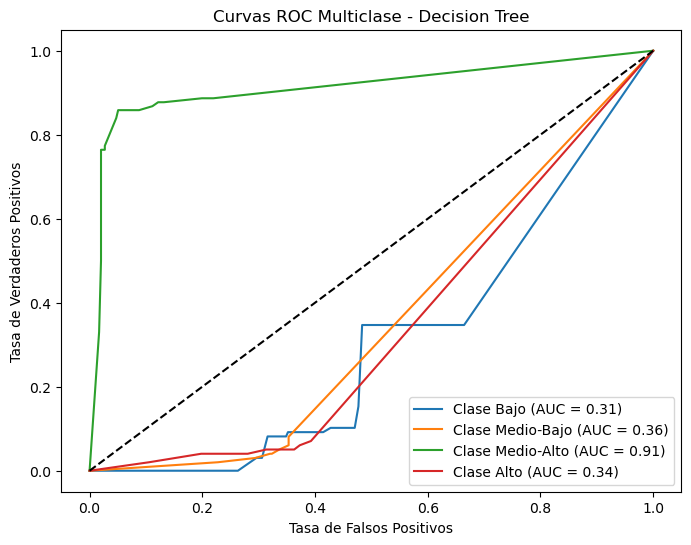

In [68]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# Binarización de las etiquetas para calcular el ROC-AUC multiclase
y_test_binarized = label_binarize(y_test, classes=y_train.cat.categories)

# Resultados de los modelos optimizados
for model_name, model in models.items():
    print(f"\n--- Evaluación del Modelo: {model_name} ---")

    # Quitar el prefijo 'classifier__' de los mejores hiperparámetros
    best_model_params = {k.replace('classifier__', ''): v for k, v in best_params[model_name].items()}

    # Crear el pipeline con los mejores hiperparámetros de cada modelo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model.__class__(**best_model_params))  # Aplicar los mejores hiperparámetros sin prefijo
    ])

    # Entrenar el modelo con el conjunto de entrenamiento completo
    pipeline.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = pipeline.predict(X_test)

    # Reporte de clasificación
    print("Reporte de Clasificación:\n", classification_report(y_test, y_pred, labels=y_train.cat.categories, target_names=y_train.cat.categories))

    # Matriz de Confusión
    conf_matrix = confusion_matrix(y_test, y_pred, labels=y_train.cat.categories)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=y_train.cat.categories, yticklabels=y_train.cat.categories)
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

    # Calcular el ROC-AUC para cada clase en el enfoque "one-vs-rest"
    if model_name == 'Logistic Regression' or model_name == 'Decision Tree':
        y_pred_proba = pipeline.predict_proba(X_test)

        # Calcular el AUC para cada clase
        roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, average="macro", multi_class="ovr")
        print(f"ROC-AUC Promedio (Macro) para {model_name}: {roc_auc:.4f}")

        # Graficar las curvas ROC para cada clase
        plt.figure(figsize=(8, 6))
        for i, class_name in enumerate(y_train.cat.categories):
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
            plt.plot(fpr, tpr, label=f'Clase {class_name} (AUC = {roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i]):.2f})')

        plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
        plt.title(f'Curvas ROC Multiclase - {model_name}')
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.legend(loc='best')
        plt.show()
